Fitting 5 folds for each of 1 candidates, totalling 5 fits


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters:  {'weights': 'uniform', 'p': 0.1, 'n_neighbors': 6, 'metric': 'manhattan'}


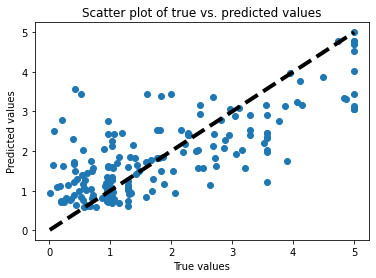

Training set:
R2: 0.6473525032220028
NSE: 0.6473525032220027
RMSE: 0.7918647365878682
MAE: 0.5562293906810035

Testing set:
R2: 0.5859473416182754
NSE: 0.5859473416182753
RMSE: 0.8824602839662405
MAE: 0.6398583333333333


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import os
import matplotlib.pyplot as plt

#new_path = 'C:/Users/fitsumteshome/Desktop/Soil moisture'
#os.chdir(new_path)
#print(os.getcwd())

# Load and preprocess the dataset
data = pd.read_csv('VIS1S2PMETmGB.csv')

# Load and preprocess the dataset
data = data.dropna() 
data['ET_wb'] = data['ET_wb'].astype(float)
#data_filted = data[(data['SM'] >= 0.) & (data['SM'] <= 0.35)]

X = data.iloc[:, [8,15]].values
#X = data_filted.iloc[:, [2,3,5,7,11,12]].values

# Perform scaling on the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

 
y = data.iloc[:, 19].values 
y = y.reshape(-1, 1)
y = np.ravel(y)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=43)
y_train = np.ravel(y_train)

# Normalize the feature data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

param_grid = {
    'n_neighbors': [6],
    'weights': ['uniform'],
    'p': [0.1],
    'metric':['manhattan'],
}

grid_search = RandomizedSearchCV( KNeighborsRegressor(), param_grid, 
                 cv = 5, n_jobs = -1, verbose = 2, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

best_pipe=grid_search.best_estimator_

y_pred = best_pipe.predict(X_test)

T4GBSM1_KNN= pd.DataFrame({'Measured': y_test.flatten(), 'Estimated': y_pred.flatten()})

# Save the DataFrame to a file
T4GBSM1_KNN.to_csv('GBSM12_KNN.csv', index=False)

#testing_loss = model.evaluate(X_test, y_test)

# Print the final training and testing loss
#print("Final training loss:", history.history['loss'][-1])
#print("Final testing loss:", testing_loss)

plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of true vs. predicted values')

# add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# show the plot
plt.show()  

y_train_pred = best_pipe.predict(X_train)
y_train = y_train.reshape(-1)
y_train_pred= y_train_pred.reshape(-1)
mean_y_train = y_train.mean()
y_train_mean = np.repeat(y_train.mean(), y_train.shape[0])

train_r2 = r2_score(y_train, y_train_pred)
train_nse = 1 - mean_squared_error(y_train, y_train_pred)/mean_squared_error(y_train, y_train_mean)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Training set:")
print("R2:", train_r2)
print("NSE:", train_nse)
print("RMSE:", train_rmse)
print("MAE:", train_mae)
print()

metricstrain = [
    {'Metric': 'RMSE', 'Value': train_r2},
    {'Metric': 'R2', 'Value': train_nse},
    {'Metric': 'NSE', 'Value': train_rmse},
    {'Metric': 'MAE', 'Value': train_mae}
]

df = pd.DataFrame(metricstrain)
df.to_csv('KNNGB_trainmetrics.csv', index=False)


y_test_pred = best_pipe.predict(X_test)
y_test = y_test.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
mean_y_test = y_test.mean()
y_test_mean = np.repeat(y_test.mean(), y_test.shape[0])

test_r2 = r2_score(y_test, y_test_pred)
test_nse = 1 - mean_squared_error(y_test, y_test_pred)/mean_squared_error(y_test, y_test_mean)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Testing set:")
print("R2:", test_r2)
print("NSE:", test_nse)
print("RMSE:", test_rmse)
print("MAE:", test_mae)

metricstest = [
    {'Metric': 'RMSE', 'Value': test_r2},
    {'Metric': 'R2', 'Value': test_nse},
    {'Metric': 'NSE', 'Value': test_rmse},
    {'Metric': 'MAE', 'Value': test_mae}
]

df = pd.DataFrame(metricstest)
df.to_csv('KNNGB_testmetrics.csv', index=False)